
# Visualization

This script is only for demo. You can modify the visualizing function to fit your own use.

The script visualizes the cumulative weight of incoming deliveries of the 5 biggest raw materials in the 150 first days of 2014

In [125]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter

# Set plot style for visual clarity
plt.style.use('seaborn-v0_8')

In [93]:
# Load the receival data
df = pd.read_csv('./data/kernel/receivals.csv')

# Convert 'date_arrival' to timezone-naive datetime
df['date_arrival'] = pd.to_datetime(df['date_arrival'], utc=True).dt.tz_localize(None)

# Filter data to include only entries from January through May 2014
mask = (df['date_arrival'] >= pd.Timestamp('2024-05-03')) & (df['date_arrival'] < pd.Timestamp('2024-05-19'))
df_2014 = df.loc[mask].copy()

In [ ]:
def visualize_cumsum_top_rm(df):
    """
    Generates a cumulative net weight plot for the top 5 most active rm_id entries.

    Parameters:
        df (pd.DataFrame): A DataFrame containing at least 'date_arrival', 'net_weight', and 'rm_id'.

    Returns:
        None. Displays a matplotlib plot.
    """
    # Identify top 5 rm_ids by total net weight
    top_rm_ids = df.groupby('rm_id')['net_weight'].sum().nlargest(5).index
    df_top = df[df['rm_id'].isin(top_rm_ids)].copy()

    # Sort data and compute cumulative sum
    df_top.sort_values(by=['rm_id', 'date_arrival'], inplace=True)
    df_top['cumsum_weight'] = df_top.groupby('rm_id')['net_weight'].cumsum()

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each rm_id group
    for rm_id, group in df_top.groupby('rm_id'):
        ax.plot(group['date_arrival'], group['cumsum_weight'], label=f"RM ID {rm_id}")

    # Format the plot
    ax.set_title('Cumulative Net Weight for Top 5 RM IDs (January–May 2014)', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Net Weight (kg)', fontsize=12)
    ax.legend(title='RM ID')
    ax.grid(True)

    # Improve date formatting on x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    # Show y-axis in kg with thousands separator, disable scientific notation
    ax.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

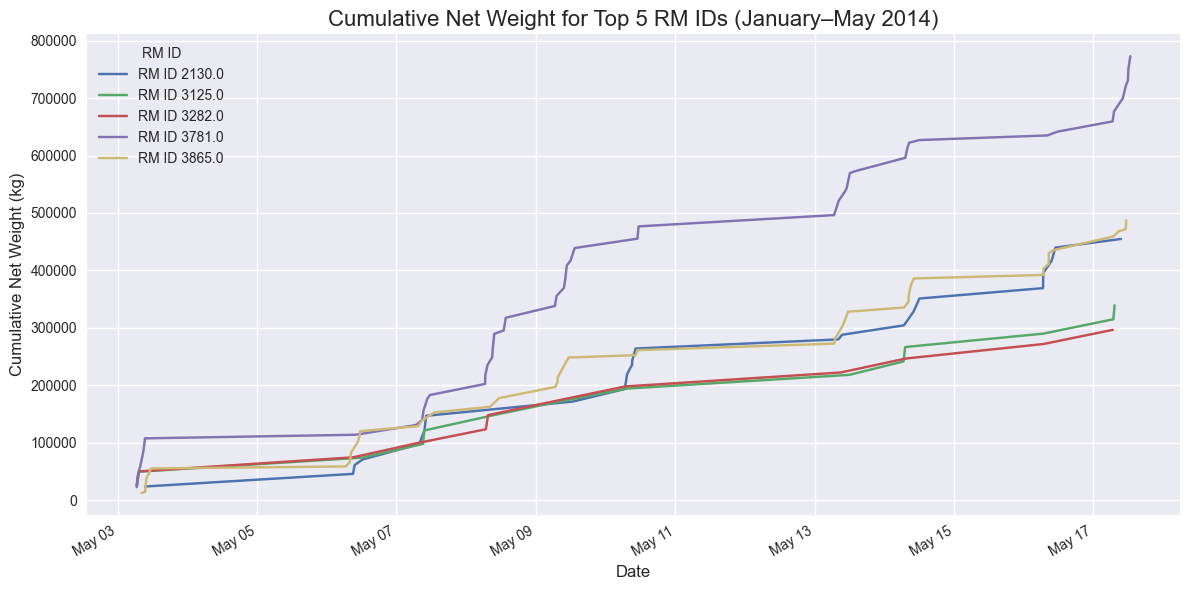

In [95]:
# Generate the visualization
visualize_cumsum_top_rm(df_2014)

In [168]:
# Last inn data
receivals = pd.read_csv("data/kernel/receivals.csv", parse_dates=["date_arrival"])
purchase_orders = pd.read_csv("data/kernel/purchase_orders.csv", parse_dates=["delivery_date"])
transportation = pd.read_csv("data/extended/transportation.csv")

neg_orders = purchase_orders[purchase_orders['quantity'] <= 0]
purchase_orders_clean = purchase_orders[purchase_orders['quantity'] > 0]
print(purchase_orders_clean[purchase_orders_clean['quantity'] < 0])

Empty DataFrame
Columns: [purchase_order_id, purchase_order_item_no, quantity, delivery_date, product_id, product_version, created_date_time, modified_date_time, unit_id, unit, status_id, status]
Index: []


In [ ]:
""" order_stats = merged.groupby(['purchase_order_id']).agg(
    ordered = ('quantity', 'first'),
    delivered = ('net_weight', 'sum'),
    n_receivals = ('purchase_order_id', 'nunique'),
    delivery_start = ('date_arrival', 'min'),
    delivery_end = ('date_arrival', 'max')
).reset_index() """

# Summer receivals per ordrelinje
receivals_grouped = receivals.groupby(
    ["purchase_order_id", "purchase_order_item_no"]
).agg(
    delivered=("net_weight", "sum"),
    n_receivals=("receival_item_no", "nunique"),   # antall del-leveranser
    delivery_start=("date_arrival", "min"),
    delivery_end=("date_arrival", "max")
).reset_index()

# Merge med purchase_orders
merged = receivals_grouped.merge(
    purchase_orders_clean,
    on=["purchase_order_id", "purchase_order_item_no"],
    how="inner"
)

# Beregn delivery ratio
merged["delivery_ratio"] = merged["delivered"] / merged["quantity"]

# Threshold for "ekstrem"
threshold = 10
merged["extreme_flag"] = merged["delivery_ratio"] > threshold



# Sammendrag
print("Delivery ratio stats (alle ordrer):")
print(merged["delivery_ratio"].describe())
print("\nDelivery ratio stats (uten ekstreme ordrer):")
print(merged.loc[~merged["extreme_flag"], "delivery_ratio"].describe())
print("\nAndel ekstreme ordrer (ratio >", threshold, "):")
print(merged["extreme_flag"].value_counts(normalize=True))

print("\nFordeling av n_receivals:")
print(merged["n_receivals"].value_counts().head(10))

# Topp 10 mest ekstreme
extreme_orders = merged[merged["extreme_flag"]].sort_values("delivery_ratio", ascending=False)
print("\nTopp 10 ekstreme ordrer:")
print(extreme_orders[[
    "purchase_order_id", 
    "purchase_order_item_no", 
    "quantity", 
    "delivered", 
    "delivery_ratio", 
    "n_receivals", 
    "delivery_start", 
    "delivery_end"
]].head(10))






Delivery ratio stats (alle ordrer):
count    22299.000000
mean         1.353834
std         23.497892
min          0.000000
25%          0.774156
50%          0.987867
75%          1.000000
max       1825.600000
Name: delivery_ratio, dtype: float64

Delivery ratio stats (uten ekstreme ordrer):
count    22275.000000
mean         0.865954
std          0.417799
min          0.000000
25%          0.773779
50%          0.987760
75%          1.000000
max          9.985160
Name: delivery_ratio, dtype: float64

Andel ekstreme ordrer (ratio > 10 ):
extreme_flag
False    0.998924
True     0.001076
Name: proportion, dtype: float64

Fordeling av n_receivals:
n_receivals
1    13100
2     6256
3     2021
4      674
5      187
6       53
7        8
Name: count, dtype: int64

Topp 10 ekstreme ordrer:
       purchase_order_id  purchase_order_item_no  quantity  delivered  \
20445           317223.0                    10.0      25.0    45640.0   
20231           316233.0                    10.0      15.0

In [158]:
""" order_stats['delivery_ratio'] = order_stats['delivered'] / order_stats['ordered']
print(order_stats['delivery_ratio'].describe())
print(order_stats['n_receivals'].value_counts().head(10)) """




" order_stats['delivery_ratio'] = order_stats['delivered'] / order_stats['ordered']\nprint(order_stats['delivery_ratio'].describe())\nprint(order_stats['n_receivals'].value_counts().head(10)) "